### Through-focus image


    # Un-debugged snippet from Emiel Por to create Gaussian phase bump
    phase_bump_pos = [0.2, 0.2]
    phase_bump_rms = pupil_diameter / 10
    phase_bump_amp = 0.75. # about pi/4

    phase_bump = phase_bump_amp * np.exp(-((pupil_grid.x - phase_bump_pos[0])**2 + \
                                           (pupil_grid.y -phase_bump_pos[1])**2) / \
                                              (2 * phase_bump_rms**2))

    aberration = np.exp(1j * phase_bump)

    wf = Wavefront(...)

    # Manually apply aberration:
    wf.electric_field *= aberration


In [1]:
from hcipy import *

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

To make life simpler later on, we define a function to nicely show two fields side-to-side, with a nice spacing, titles and axes labels.



In [2]:
def double_plot(a, b, title='', xlabel='', ylabel='', **kwargs):
    '''A function to nicely show two fields side-to-side.
    '''
    fig, axes = plt.subplots(1, 2, gridspec_kw={'left': 0.14, 'right': 0.98, 'top': 0.95, 'bottom': 0.07, 'wspace': 0.02})
    fig.suptitle(title)

    imshow_field(a, **kwargs, ax=axes[0])
    imshow_field(b, **kwargs, ax=axes[1])

    axes[1].yaxis.set_ticks([])
    axes[0].set_xlabel(xlabel)
    axes[1].set_xlabel(xlabel)
    axes[0].set_ylabel(ylabel)

    return fig

Now we can create the pupils. Each pupil will have the same diameter of 3mm, and we’ll use a wavelength of 500nm. Each pupil is evaluated with supersampling, meaning that the value at each pixel will be the average of, in our case, 8x8=64 subpixels. We’ll use 256 pixels across and enlarge the pupil plane slightly to be able to see the details in the near-field diffraction just outside of the pupil.

And plotting both apertures next to each other:

In [3]:
def easing(start, end, n):
    x = np.linspace(0, 1, n)
    y = np.where(x < 0.5, 4 * x**3, 1 - 4 * (1 - x)**3)

    return y * (end - start) + start



### Far-field propagation through focus
We simulate moving through the focal plane by using steps of defocus - a quadratic phase aberration in the pupil - which keeps the image pixel scale the same through focus.(Moving the detector changes the scale, a slight complication we ignore here.  But if you move your lens or detector, remember to change your image plane pixel scale!)

First we recreate a pupil and pupil grid to suit, and a perfect wavefront for the two geometries

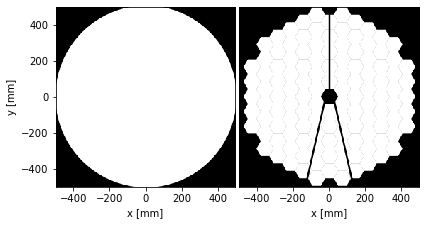

In [4]:
pupil_diameter = 1.0 # meter
wavelength = 5e-6 # meter
focal_length = 5.0 # m

# size the pupil exactly to pupil diameter
pupil_grid = make_pupil_grid(256, 1.0 * pupil_diameter)
aperture_circ = evaluate_supersampled(circular_aperture(pupil_diameter), pupil_grid, 8)

aperture_luvoir = evaluate_supersampled(make_luvoir_a_aperture(True), pupil_grid.scaled(1 / pupil_diameter), 8)
aperture_luvoir.grid = pupil_grid

double_plot(aperture_circ, aperture_luvoir,
            xlabel='x [mm]', ylabel='y [mm]',
            grid_units=1e-3, cmap='gray')
plt.show()


wf_circ = Wavefront(aperture_circ, wavelength)
wf_luvoir = Wavefront(aperture_luvoir, wavelength)

spatial_resolution = focal_length / pupil_diameter * wavelength
focal_grid = make_focal_grid(8, 12, spatial_resolution=spatial_resolution)

fraunhofer = FraunhoferPropagator(pupil_grid, focal_grid, focal_length=focal_length)

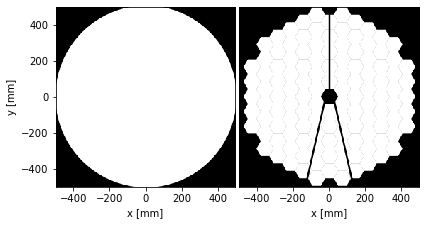

In [5]:
double_plot(aperture_circ, aperture_luvoir,
            xlabel='x [mm]', ylabel='y [mm]',
            grid_units=1e-3, cmap='gray')
plt.show()

In [6]:
# Quadratic bowl with max value 1 at pupil edges (more or less with the non-circlar geometry): Peak-to-Valley
# Actual max at square array corners will be 2, but the corners are not illuminated...
pupil_radius = pupil_diameter / 2.0
quadratic_PVunity = (pupil_grid.x/pupil_radius)**2 + (pupil_grid.y/pupil_radius)**2

print(pupil_grid.x.max(), pupil_grid.x.min(), quadratic_PVunity.max())


0.498046875 -0.498046875 1.984405517578125


In [7]:
# Create a bump array with std dev 1/10 pupil diameter
phase_bump_pos = [0.2, 0.2]
phase_bump_rms = pupil_diameter / 4
phase_bump_amp = 1.5 # rad?

phase_bump = phase_bump_amp * np.exp(-((pupil_grid.x - phase_bump_pos[0])**2 + \
                                       (pupil_grid.y -phase_bump_pos[1])**2) / \
                                          (2 * phase_bump_rms**2))

print(phase_bump.max(), phase_bump.min())

1.4999670413777206 0.0006168739024128351


In [9]:
n = 10
defocusPV_waves = np.concatenate([easing(-1, -0.0, n),
                                  easing(0.0, 1.0, n),])

print(defocusPV_waves.max(), defocusPV_waves.min())
#img_circ = fraunhofer(wf_circ)
#img_luvoir = fraunhofer(wf_luvoir)


# Starting the animation object to write to an mp4 file.
anim = FFMpegWriter('throughfocus.mp4', framerate=15)

for defocus in defocusPV_waves:
    print('defocus/waves: ', defocus, ' ', end='')
    phase = 2 * np.pi * defocus + phase_bump
    print('phase: ', phase.max())
 
    
    wf_circ = Wavefront(aperture_circ, wavelength)
    wf_luvoir = Wavefront(aperture_luvoir, wavelength)

    wf_circ_aberrated = wf_circ
    wf_circ_aberrated.electric_field *= np.exp(1j * phase)
    
    wf_luvoir_aberrated = wf_luvoir
    wf_luvoir_aberrated.electric_field *= np.exp(1j * phase)
    
    img_circ = fraunhofer(wf_circ_aberrated)
    img_luvoir = fraunhofer(wf_luvoir_aberrated)

    double_plot(np.log10(img_circ.power / img_circ.power.max()), np.log10(img_luvoir.power / img_luvoir.power.max()),
                title='Wavelength: %d nm' % (wavelength * 1e9),
                xlabel='x [um]', ylabel='y [um]',
                vmin=-6, cmap='inferno', grid_units=1e-6)

    anim.add_frame()
    plt.close()

anim.close()

anim


1.0 -1.0
defocus/waves:  -1.0  phase:  -4.783218265801866
defocus/waves:  -0.9945130315500685  phase:  -4.748742626256298
defocus/waves:  -0.9561042524005487  phase:  -4.50741314943733
defocus/waves:  -0.8518518518518519  phase:  -3.8523759980715564
defocus/waves:  -0.6488340192043897  phase:  -2.576777334885578
defocus/waves:  -0.35116598079561034  phase:  -0.7064738895385672
defocus/waves:  -0.14814814814814814  phase:  0.5691247736474117
defocus/waves:  -0.04389574759945136  phase:  1.2241619250131843
defocus/waves:  -0.005486968449931462  phase:  1.4654914018321534
defocus/waves:  0.0  phase:  1.4999670413777206
defocus/waves:  0.0  phase:  1.4999670413777206
defocus/waves:  0.005486968449931412  phase:  1.5344426809232876
defocus/waves:  0.04389574759945129  phase:  1.7757721577422565
defocus/waves:  0.1481481481481481  phase:  2.4308093091080294
defocus/waves:  0.35116598079561034  phase:  3.7064079722940084
defocus/waves:  0.6488340192043897  phase:  5.576711417641019
defocus/wa

In [ ]:
# Cleanup created files
os.remove('throughfocus.mp4')